# Pipeline prolijo: métricas de clientes y target futuro

Este notebook crea dos artefactos principales:
1) `df_train_metrics`: métricas por cliente calculadas usando órdenes hasta la fecha de referencia 2024-06-01 (sin target).
2) `df_train_with_target`: `df_train_metrics` con la columna `target` derivada del conteo de órdenes en la ventana futura 2024-06-01 → 2024-09-30 (target=1 si NO hay órdenes en esa ventana).

Todas las operaciones son no destructivas respecto a `df_orders` original: se crean copias filtradas y agregadas.


In [21]:
# Imports y opciones de visualización
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)


In [22]:
# Leer los CSVs (rutas relativas a la carpeta del repo)
df_clientes = pd.read_csv('data/clients_202510280926.csv')
df_orders = pd.read_csv('data/orders_202510280929.csv')
df_products = pd.read_csv('data/products_202510280931.csv')

# Vista rápida
print('clientes:', df_clientes.shape, 'orders:', df_orders.shape, 'products:', df_products.shape)
df_clientes.head()


clientes: (2357, 15) orders: (82245, 10) products: (1255, 6)


,client_id,first_name,last_name,gender,age,email,city,address,postal_code,country,citizenship,document_type,document_number,registration_date,last_seen
0,21e5c13d-1c9a-4d00-9164-b72302d5edef,Tristán,Rojas,M,42,tristán.rojas13@example.com,Rivera,Bulevar Artigas 3757,28289,Uruguay,Uruguay,CI,2719583-8,2025-05-02 00:00:00.000,2025-06-19 00:00:00.000
1,36e48bdd-db11-4abe-9526-cfc90e68924d,Óscar,Barranco,M,58,óscar.barranco13@example.com,Salto,Bulevar Artigas 3911,76237,Uruguay,Uruguay,CI,1445199-8,2023-02-24 00:00:00.000,2023-12-09 00:00:00.000
2,145c22df-3579-412e-bc12-b4fce70abaf3,Macario,Querol,M,28,macario.querol67@example.com,Rivera,Av. Rivera 206,30926,Uruguay,Uruguay,CI,8090293-5,2024-10-03 00:00:00.000,2025-05-03 00:00:00.000
3,90c4a925-e51f-4dac-9193-2d9aec97a472,Ramiro,Sanchez,M,19,ramiro.sanchez53@example.com,Salto,Av. 18 de Julio 6324,22676,Uruguay,Uruguay,CI,7022674-5,2025-01-13 00:00:00.000,2025-08-11 00:00:00.000
4,853f711a-4c36-40b4-b5d0-6207152cd793,Juan Francisco,Flor,M,36,juan francisco.flor68@example.com,Mercedes,Av. 18 de Julio 6301,20328,Uruguay,Uruguay,CI,5918715-9,2025-03-09 00:00:00.000,2025-03-21 00:00:00.000


In [23]:
# Crear df_orders_products sin modificar df_orders original
df_orders_products = df_orders.merge(df_products, left_on='product_id', right_on='product_id', how='left', suffixes=('_order','_product'))

# Asegurar tipo fecha
df_orders_products['order_timestamp'] = pd.to_datetime(df_orders_products['order_timestamp'])

print('df_orders_products filas:', df_orders_products.shape[0])
df_orders_products.head()


df_orders_products filas: 82245


,order_id,client_id,product_id,product_category,order_price,order_timestamp,order_status,payment_method,shipping_method,shipping_cost,product_name,category,brand,last_updated,created_at
0,1,6c5c87f2-49e9-4380-872d-71d9e3df63d6,P00333,Snacks,29.51,2023-01-01 23:51:55,delivered,bank_transfer,standard,3.51,Snickers,Snacks,Mars,2025-09-06 21:21:31.000,2025-06-13 21:21:31.000
1,2,0c8380cb-a64e-4090-8b23-d1ddf32630e0,P00929,Personal Care,23.40,2023-01-01 11:48:50,delivered,credit_card,standard,3.76,Colgate Toothpaste,Personal Care,Colgate-Palmolive,2025-09-06 21:21:31.000,2025-02-25 21:21:31.000
2,3,bf486527-8182-490e-9e10-c79232c6b0c9,P00768,Personal Care,94.41,2023-01-01 11:06:14,delivered,debit_card,express,10.42,Gillette Razor,Personal Care,P&G,2025-09-06 21:21:31.000,2025-07-07 21:21:31.000
3,5,6c5c87f2-49e9-4380-872d-71d9e3df63d6,P00610,Household,29.16,2023-01-01 20:55:35,delivered,credit_card,standard,6.05,Fairy Dish Soap,Household,P&G,2025-09-06 21:21:31.000,2025-04-23 21:21:31.000
4,6,7ac7a850-4f19-4c85-921b-b0e5ba921ee9,P00299,Snacks,76.22,2023-01-01 02:49:09,delivered,debit_card,express,14.08,Snickers,Snacks,Mars,2025-09-06 21:21:31.000,2025-02-27 21:21:31.000


In [24]:
# Función helper: construir métricas por cliente dadas órdenes y fecha de referencia
def build_customer_metrics(df, fecha_ref):
    df = df.copy()
    df['order_timestamp'] = pd.to_datetime(df['order_timestamp'])
    # Fecha de referencia como Timestamp
    fecha_ref = pd.to_datetime(fecha_ref)

    # Categoria favorita por número de órdenes
    fav_category = (
        df.groupby(['client_id', 'product_category']).size()
        .reset_index(name='count')
        .sort_values(['client_id', 'count'], ascending=[True, False])
        .drop_duplicates('client_id')
        .rename(columns={'product_category': 'favorite_category'})
    )

    # Agregados principales
    agg = df.groupby('client_id').agg(
        total_orders=('order_timestamp','count'),
        first_order_date=('order_timestamp','min'),
        last_order_date=('order_timestamp','max'),
        total_spent=('order_price','sum'),
        average_order_value=('order_price','mean'),
        std_order_value=('order_price','std'),
        max_order_value=('order_price','max'),
        min_order_value=('order_price','min'),
        total_shipping_cost=('shipping_cost','sum'),
        avg_shipping_cost=('shipping_cost','mean'),
        unique_categories=('product_category','nunique'),
        unique_brands=('brand','nunique'),
        unique_payment_methods=('payment_method','nunique'),
        unique_shipping_methods=('shipping_method','nunique'),
        cancelled_orders=('order_status', lambda x: (x=='failed').sum()),
        express_shipping_ratio=('shipping_method', lambda x: x.str.contains('express', case=False).mean() if x.notna().any() else 0),
        most_used_payment_method=('payment_method', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
        most_used_shipping_method=('shipping_method', lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    ).reset_index()

    # Features temporales respecto a fecha_ref
    agg['days_since_last_order'] = (fecha_ref - agg['last_order_date']).dt.days
    agg['customer_lifespan_days'] = (fecha_ref - agg['first_order_date']).dt.days
    agg['avg_days_between_orders'] = agg['customer_lifespan_days'] / agg['total_orders']
    agg['delay_vs_avg_interval'] = agg['days_since_last_order'] - agg['avg_days_between_orders']

    # Meses activos
    df['month'] = df['order_timestamp'].dt.to_period('M')
    months_active = df.groupby('client_id')['month'].nunique().reset_index(name='months_active')
    agg = agg.merge(months_active, on='client_id', how='left')

    # Categoria favorita y gasto en ella
    agg = agg.merge(fav_category[['client_id','favorite_category']], on='client_id', how='left')
    spend_by_cat = df.groupby(['client_id','product_category'])['order_price'].sum().reset_index()
    spend_fav = spend_by_cat.merge(fav_category[['client_id','favorite_category']], on='client_id')
    spend_fav = spend_fav[spend_fav['product_category'] == spend_fav['favorite_category']]
    spend_fav = spend_fav.rename(columns={'order_price':'favorite_category_spend'})
    agg = agg.merge(spend_fav[['client_id','favorite_category_spend']], on='client_id', how='left')
    agg['fav_category_spend_ratio'] = agg['favorite_category_spend'] / agg['total_spent']

    # Reemplazar NaNs sensatos
    agg.fillna({
        'std_order_value': 0,
        'favorite_category_spend': 0,
        'fav_category_spend_ratio': 0,
        'months_active': 0
    }, inplace=True)

    # Ordenar columnas (si existen)
    cols = [
        'client_id','total_orders','first_order_date','last_order_date',
        'days_since_last_order','customer_lifespan_days','avg_days_between_orders','delay_vs_avg_interval',
        'total_spent','average_order_value','std_order_value','max_order_value','min_order_value',
        'total_shipping_cost','avg_shipping_cost','unique_categories','unique_brands',
        'unique_payment_methods','unique_shipping_methods','cancelled_orders','express_shipping_ratio',
        'months_active','most_used_payment_method','most_used_shipping_method',
        'favorite_category','favorite_category_spend','fav_category_spend_ratio'
    ]
    agg = agg[[c for c in cols if c in agg.columns]]
    return agg


In [25]:
# 1) df_train: órdenes hasta 2024-06-01 (inclusive) y cálculo de métricas
fecha_ref_train = '2024-06-01'
df_train = df_orders_products[df_orders_products['order_timestamp'] <= pd.to_datetime(fecha_ref_train)].reset_index(drop=True)
print('Órdenes en df_train:', df_train.shape[0])
df_train_metrics = build_customer_metrics(df_train, fecha_ref_train)
print('Clientes con métricas (train):', df_train_metrics.shape[0])
df_train_metrics.head()


Órdenes en df_train: 59252
Clientes con métricas (train): 2210
Clientes con métricas (train): 2210


,client_id,total_orders,first_order_date,last_order_date,days_since_last_order,customer_lifespan_days,avg_days_between_orders,delay_vs_avg_interval,total_spent,average_order_value,std_order_value,max_order_value,min_order_value,total_shipping_cost,avg_shipping_cost,unique_categories,unique_brands,unique_payment_methods,unique_shipping_methods,cancelled_orders,express_shipping_ratio,months_active,most_used_payment_method,most_used_shipping_method,favorite_category,favorite_category_spend,fav_category_spend_ratio
0,00094d4c-1acd-46ec-a6d2-c35710c31005,2,2023-11-17 03:46:17,2024-04-27 17:58:43,34,196,98.000000,-64.000000,133.85,66.925000,16.638223,78.69,55.16,12.15,6.075000,2,2,2,1,0,0.000000,2,credit_card,standard,Snacks,55.16,0.412103
1,0016d161-d6a2-42f3-bfd6-66aee6d163e3,4,2023-01-03 14:33:10,2023-07-11 15:17:43,325,514,128.500000,196.500000,235.11,58.777500,36.255436,88.26,5.87,28.63,7.157500,2,3,3,2,1,0.250000,4,debit_card,standard,Beverages,76.90,0.327081
2,0042e01f-9154-45fd-9c1d-499b3eb3f1c4,56,2023-01-16 05:43:41,2024-05-31 06:25:03,0,501,8.946429,-8.946429,2838.69,50.690893,29.028746,101.05,1.06,329.55,5.884821,5,17,5,3,1,0.267857,17,credit_card,standard,Household,1018.60,0.358827
3,0052b716-46cf-4540-aa23-409642dc4048,51,2023-01-12 04:44:03,2024-05-19 07:45:48,12,505,9.901961,2.098039,2628.76,51.544314,28.311151,98.59,1.49,286.84,5.624314,5,18,5,3,0,0.196078,15,credit_card,standard,Snacks,600.84,0.228564
4,00679c7c-bd80-4a70-9052-830bc5b63ecf,60,2023-01-30 09:58:29,2024-05-25 05:21:00,6,487,8.116667,-2.116667,3614.69,60.244833,23.180498,101.47,8.05,313.75,5.229167,5,15,5,3,0,0.200000,15,credit_card,standard,Technology,1739.32,0.481181


In [26]:
# 2) df_future: ventana 2024-06-01 → 2024-09-30 (inclusive) y cálculo del target
start_future = pd.to_datetime('2024-06-01')
end_future = pd.to_datetime('2024-09-30')
df_future = df_orders_products[(df_orders_products['order_timestamp'] >= start_future) & (df_orders_products['order_timestamp'] <= end_future)].reset_index(drop=True)
print('Órdenes en ventana futura:', df_future.shape[0])
# Contar órdenes por cliente en la ventana futura
df_future_counts = df_future.groupby('client_id').size().reset_index(name='future_orders')
# Merge con todos los clientes de df_train_metrics para obtener target para cada cliente entrenable
df_train_with_target = df_train_metrics.merge(df_future_counts, on='client_id', how='left')
# Clientes sin registros en df_future_counts tienen 0 órdenes en la ventana futura => target=1
df_train_with_target['future_orders'] = df_train_with_target['future_orders'].fillna(0).astype(int)
df_train_with_target['target'] = (df_train_with_target['future_orders'] == 0).astype(int)
print('Distribución target (1 = no compró en la ventana futura):')
print(df_train_with_target['target'].value_counts(dropna=False).to_string())
df_train_with_target.head()


Órdenes en ventana futura: 13094
Distribución target (1 = no compró en la ventana futura):
target
0    1865
1     345


,client_id,total_orders,first_order_date,last_order_date,days_since_last_order,customer_lifespan_days,avg_days_between_orders,delay_vs_avg_interval,total_spent,average_order_value,std_order_value,max_order_value,min_order_value,total_shipping_cost,avg_shipping_cost,unique_categories,unique_brands,unique_payment_methods,unique_shipping_methods,cancelled_orders,express_shipping_ratio,months_active,most_used_payment_method,most_used_shipping_method,favorite_category,favorite_category_spend,fav_category_spend_ratio,future_orders,target
0,00094d4c-1acd-46ec-a6d2-c35710c31005,2,2023-11-17 03:46:17,2024-04-27 17:58:43,34,196,98.000000,-64.000000,133.85,66.925000,16.638223,78.69,55.16,12.15,6.075000,2,2,2,1,0,0.000000,2,credit_card,standard,Snacks,55.16,0.412103,0,1
1,0016d161-d6a2-42f3-bfd6-66aee6d163e3,4,2023-01-03 14:33:10,2023-07-11 15:17:43,325,514,128.500000,196.500000,235.11,58.777500,36.255436,88.26,5.87,28.63,7.157500,2,3,3,2,1,0.250000,4,debit_card,standard,Beverages,76.90,0.327081,0,1
2,0042e01f-9154-45fd-9c1d-499b3eb3f1c4,56,2023-01-16 05:43:41,2024-05-31 06:25:03,0,501,8.946429,-8.946429,2838.69,50.690893,29.028746,101.05,1.06,329.55,5.884821,5,17,5,3,1,0.267857,17,credit_card,standard,Household,1018.60,0.358827,13,0
3,0052b716-46cf-4540-aa23-409642dc4048,51,2023-01-12 04:44:03,2024-05-19 07:45:48,12,505,9.901961,2.098039,2628.76,51.544314,28.311151,98.59,1.49,286.84,5.624314,5,18,5,3,0,0.196078,15,credit_card,standard,Snacks,600.84,0.228564,10,0
4,00679c7c-bd80-4a70-9052-830bc5b63ecf,60,2023-01-30 09:58:29,2024-05-25 05:21:00,6,487,8.116667,-2.116667,3614.69,60.244833,23.180498,101.47,8.05,313.75,5.229167,5,15,5,3,0,0.200000,15,credit_card,standard,Technology,1739.32,0.481181,11,0


In [27]:
df_train_with_target = df_train_with_target.drop(['future_orders'], axis=1)

In [28]:
df_train_with_target.head()

,client_id,total_orders,first_order_date,last_order_date,days_since_last_order,customer_lifespan_days,avg_days_between_orders,delay_vs_avg_interval,total_spent,average_order_value,std_order_value,max_order_value,min_order_value,total_shipping_cost,avg_shipping_cost,unique_categories,unique_brands,unique_payment_methods,unique_shipping_methods,cancelled_orders,express_shipping_ratio,months_active,most_used_payment_method,most_used_shipping_method,favorite_category,favorite_category_spend,fav_category_spend_ratio,target
0,00094d4c-1acd-46ec-a6d2-c35710c31005,2,2023-11-17 03:46:17,2024-04-27 17:58:43,34,196,98.000000,-64.000000,133.85,66.925000,16.638223,78.69,55.16,12.15,6.075000,2,2,2,1,0,0.000000,2,credit_card,standard,Snacks,55.16,0.412103,1
1,0016d161-d6a2-42f3-bfd6-66aee6d163e3,4,2023-01-03 14:33:10,2023-07-11 15:17:43,325,514,128.500000,196.500000,235.11,58.777500,36.255436,88.26,5.87,28.63,7.157500,2,3,3,2,1,0.250000,4,debit_card,standard,Beverages,76.90,0.327081,1
2,0042e01f-9154-45fd-9c1d-499b3eb3f1c4,56,2023-01-16 05:43:41,2024-05-31 06:25:03,0,501,8.946429,-8.946429,2838.69,50.690893,29.028746,101.05,1.06,329.55,5.884821,5,17,5,3,1,0.267857,17,credit_card,standard,Household,1018.60,0.358827,0
3,0052b716-46cf-4540-aa23-409642dc4048,51,2023-01-12 04:44:03,2024-05-19 07:45:48,12,505,9.901961,2.098039,2628.76,51.544314,28.311151,98.59,1.49,286.84,5.624314,5,18,5,3,0,0.196078,15,credit_card,standard,Snacks,600.84,0.228564,0
4,00679c7c-bd80-4a70-9052-830bc5b63ecf,60,2023-01-30 09:58:29,2024-05-25 05:21:00,6,487,8.116667,-2.116667,3614.69,60.244833,23.180498,101.47,8.05,313.75,5.229167,5,15,5,3,0,0.200000,15,credit_card,standard,Technology,1739.32,0.481181,0


## Modelado supervisado: preparación de datos, análisis y entrenamientos

A continuación: dividiremos el dataset en train/test (80/20), realizaremos un análisis breve de variables, luego entrenaremos varios modelos supervisados y compararemos sus métricas (ROC-AUC, F1, Accuracy, Precision, Recall, PR-AUC).

In [29]:
# Imports adicionales para modelado
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42


In [30]:
# Preparar X, y (sin columnas con información futura ni IDs)
X = df_train_with_target.copy()
y = X.pop('target')
# Eliminar columnas no predictivas o sensibles
for c in ['client_id', 'first_order_date', 'last_order_date']:
    if c in X.columns:
        X = X.drop(columns=[c])

# Detectar numéricas y categóricas
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print('Features numéricas:', len(numeric_cols), numeric_cols)
print('Features categóricas:', len(categorical_cols), categorical_cols)

# Split 80/20 con estratificación por target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('Train:', X_train.shape, 'Test:', X_test.shape)
print('Balance train:', y_train.value_counts(normalize=True).to_dict(), 'Balance test:', y_test.value_counts(normalize=True).to_dict())


Features numéricas: 21 ['total_orders', 'days_since_last_order', 'customer_lifespan_days', 'avg_days_between_orders', 'delay_vs_avg_interval', 'total_spent', 'average_order_value', 'std_order_value', 'max_order_value', 'min_order_value', 'total_shipping_cost', 'avg_shipping_cost', 'unique_categories', 'unique_brands', 'unique_payment_methods', 'unique_shipping_methods', 'cancelled_orders', 'express_shipping_ratio', 'months_active', 'favorite_category_spend', 'fav_category_spend_ratio']
Features categóricas: 3 ['most_used_payment_method', 'most_used_shipping_method', 'favorite_category']
Train: (1768, 24) Test: (442, 24)
Balance train: {0: 0.8438914027149321, 1: 0.15610859728506787} Balance test: {0: 0.8438914027149321, 1: 0.15610859728506787}


In [31]:
# Análisis exploratorio rápido de variables

# 1) Distribución de la variable objetivo
print('Conteo de target en train:')
print(y_train.value_counts())

# 2) Correlaciones numéricas con target (punto-biserial aproximado con corr de Pearson)
if len(numeric_cols) > 0:
    corr_df = pd.concat([X_train[numeric_cols], y_train.rename('target')], axis=1).corr()
    corr_with_target = corr_df['target'].drop('target').abs().sort_values(ascending=False)
    print('\nTop 10 features numéricas por correlación absoluta con target:')
    display(corr_with_target.head(10))

# 3) Para categóricas: mostrar top categorías por tasa de compra (target mean)
for cat in categorical_cols:
    tmp = pd.concat([X_train[cat], y_train.rename('target')], axis=1)
    stats = tmp.groupby(cat)['target'].agg(['mean','count']).sort_values('count', ascending=False).head(5)
    print(f"\nCategoría: {cat} — top 5 valores por frecuencia (mean target, count):")
    display(stats)


Conteo de target en train:
target
0    1492
1     276
Name: count, dtype: int64

Top 10 features numéricas por correlación absoluta con target:


unique_payment_methods     0.525796
months_active              0.524251
unique_categories          0.520894
unique_shipping_methods    0.482750
unique_brands              0.477935
avg_days_between_orders    0.460965
days_since_last_order      0.451473
min_order_value            0.418575
customer_lifespan_days     0.401617
max_order_value            0.397149
Name: target, dtype: float64


Categoría: most_used_payment_method — top 5 valores por frecuencia (mean target, count):


,mean,count
most_used_payment_method,,
credit_card,0.112588,1279
debit_card,0.225410,244
cash,0.293333,150
bank_transfer,0.347222,72
paypal,0.347826,23



Categoría: most_used_shipping_method — top 5 valores por frecuencia (mean target, count):


,mean,count
most_used_shipping_method,,
standard,0.129790,1618
express,0.405172,116
pickup,0.558824,34



Categoría: favorite_category — top 5 valores por frecuencia (mean target, count):


,mean,count
favorite_category,,
Technology,0.106845,599
Household,0.153318,437
Beverages,0.193431,274
Personal Care,0.193966,232
Snacks,0.207965,226


In [33]:
# Preprocesador: imputación + escalado para numéricas, imputación + one-hot para categóricas
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [34]:
# Función de evaluación para un pipeline ya entrenado
def evaluate_model(pipe, X_test, y_test, name=None):
    y_pred = pipe.predict(X_test)
    y_proba = None
    try:
        y_proba = pipe.predict_proba(X_test)[:,1]
    except Exception:
        # Algunos modelos no implementan predict_proba
        pass

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    pr_auc = average_precision_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"--- Resultado: {name} ---")
    print('Accuracy:', round(acc,4), 'F1:', round(f1,4), 'Precision:', round(prec,4), 'Recall:', round(rec,4), 'ROC-AUC:', round(roc,4) if not np.isnan(roc) else 'n/a', 'PR-AUC:', round(pr_auc,4) if not np.isnan(pr_auc) else 'n/a')
    print('\nClassification report:\n', classification_report(y_test, y_pred, zero_division=0))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
    return dict(accuracy=acc, f1=f1, precision=prec, recall=rec, roc_auc=roc, pr_auc=pr_auc)


In [35]:
# Definir modelos a evaluar
def make_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('clf', model)
    ])

models = {
    'LogisticRegression': make_pipeline(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    'DecisionTree': make_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE)),
    'RandomForest': make_pipeline(RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)),
    'GradientBoosting': make_pipeline(GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE))
}

results = {}
for name, pipe in models.items():
    print('\n\nTraining', name)
    pipe.fit(X_train, y_train)
    res = evaluate_model(pipe, X_test, y_test, name=name)
    # cross-val ROC-AUC (rápido)
    try:
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='roc_auc')
        res['cv_roc_auc_mean'] = float(np.mean(cv_scores))
        res['cv_roc_auc_std'] = float(np.std(cv_scores))
    except Exception as e:
        res['cv_roc_auc_mean'] = np.nan
        res['cv_roc_auc_std'] = np.nan
    results[name] = res

# Resumen en DataFrame
metrics_df = pd.DataFrame.from_dict(results, orient='index')
metrics_df = metrics_df[['accuracy','f1','precision','recall','roc_auc','pr_auc','cv_roc_auc_mean','cv_roc_auc_std']]
metrics_df



Training LogisticRegression
--- Resultado: LogisticRegression ---
Accuracy: 0.8778 F1: 0.5781 Precision: 0.6271 Recall: 0.5362 ROC-AUC: 0.9331 PR-AUC: 0.6814

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       373
           1       0.63      0.54      0.58        69

    accuracy                           0.88       442
   macro avg       0.77      0.74      0.75       442
weighted avg       0.87      0.88      0.87       442

Confusion matrix:
 [[351  22]
 [ 32  37]]


Training DecisionTree
--- Resultado: DecisionTree ---
Accuracy: 0.8235 F1: 0.4179 Precision: 0.4308 Recall: 0.4058 ROC-AUC: 0.6533 PR-AUC: 0.2676

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90       373
           1       0.43      0.41      0.42        69

    accuracy                           0.82       442
   macro avg       0.66      0.65      0.66       442
w

,accuracy,f1,precision,recall,roc_auc,pr_auc,cv_roc_auc_mean,cv_roc_auc_std
LogisticRegression,0.877828,0.578125,0.627119,0.536232,0.933131,0.681367,0.909441,0.007886
DecisionTree,0.823529,0.417910,0.430769,0.405797,0.653301,0.267565,0.730786,0.016362
RandomForest,0.895928,0.629032,0.709091,0.565217,0.938552,0.670131,0.919042,0.010174
GradientBoosting,0.861991,0.512000,0.571429,0.463768,0.925050,0.633116,0.916980,0.008161



Top features para RandomForest:


total_orders                0.076656
total_spent                 0.073663
total_shipping_cost         0.072852
avg_days_between_orders     0.067116
days_since_last_order       0.061945
unique_brands               0.057643
favorite_category_spend     0.052312
cancelled_orders            0.050585
min_order_value             0.047888
delay_vs_avg_interval       0.044820
fav_category_spend_ratio    0.044028
max_order_value             0.038820
average_order_value         0.036545
months_active               0.036023
customer_lifespan_days      0.035994
avg_shipping_cost           0.035027
std_order_value             0.029972
unique_payment_methods      0.025933
unique_categories           0.024524
express_shipping_ratio      0.019184
dtype: float64

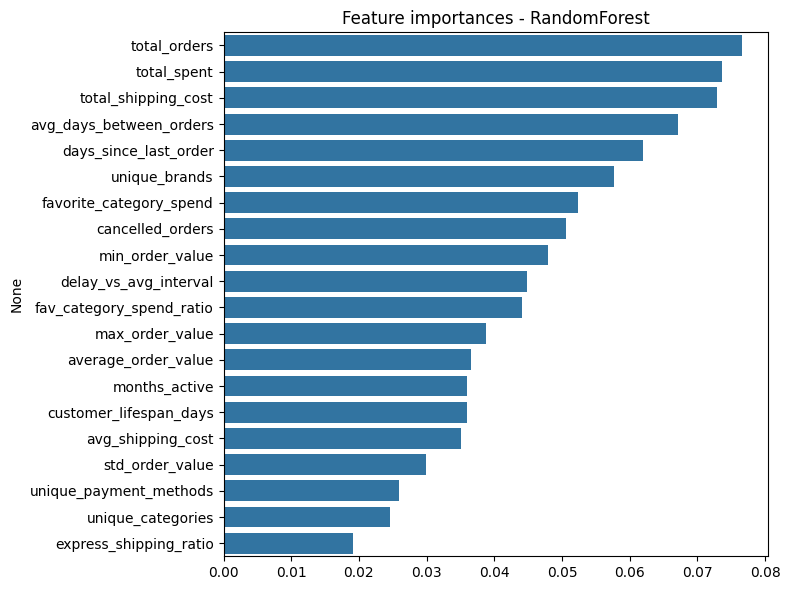


Top features para GradientBoosting:


total_spent                             0.408264
cancelled_orders                        0.144893
total_shipping_cost                     0.056804
min_order_value                         0.043101
avg_shipping_cost                       0.036639
unique_brands                           0.033657
std_order_value                         0.033214
customer_lifespan_days                  0.032545
average_order_value                     0.030978
favorite_category_spend                 0.030404
days_since_last_order                   0.028076
max_order_value                         0.023898
unique_payment_methods                  0.018749
avg_days_between_orders                 0.017206
fav_category_spend_ratio                0.016341
delay_vs_avg_interval                   0.015890
most_used_payment_method_credit_card    0.004765
favorite_category_Personal Care         0.004094
favorite_category_Household             0.003567
favorite_category_Snacks                0.003542
dtype: float64

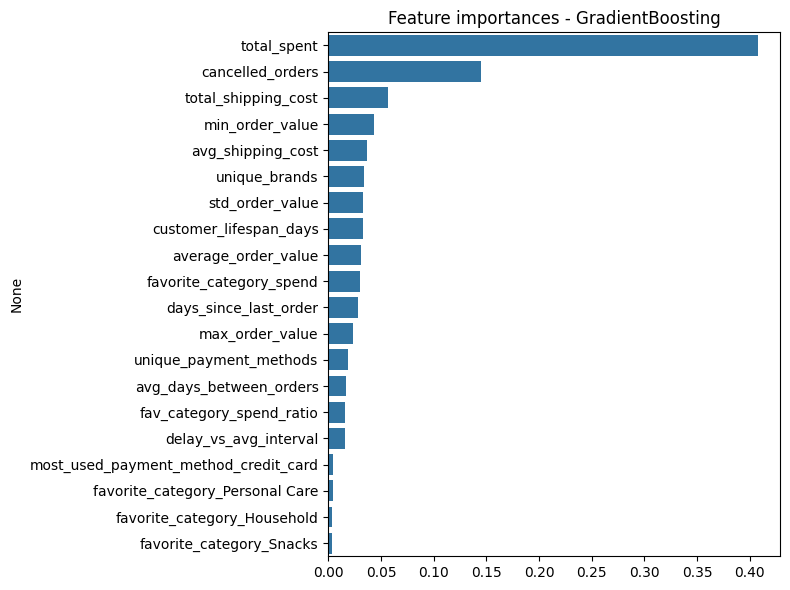

In [37]:
# Feature importances para modelos basados en árboles (RandomForest y GradientBoosting)

def get_feature_names(preprocessor):
    # nombres de features resultantes después del preprocesamiento
    num_feats = numeric_cols
    cat_feats = []
    if len(categorical_cols) > 0:
        # obtener nombres del onehot
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_names = list(ohe.get_feature_names_out(categorical_cols))
        cat_feats = cat_names
    return list(num_feats) + list(cat_feats)

for name in ['RandomForest','GradientBoosting']:
    if name in models:
        pipe = models[name]
        # ya están entrenados en la celda anterior
        try:
            importances = pipe.named_steps['clf'].feature_importances_
            feature_names = get_feature_names(pipe.named_steps['preprocessor'])
            fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
            print(f"\nTop features para {name}:")
            display(fi)
            plt.figure(figsize=(8,6))
            sns.barplot(x=fi.values, y=fi.index)
            plt.title(f'Feature importances - {name}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print('No se pudo extraer feature importances para', name, str(e))


### MLflow: registrar experimentos y modelos

En esta sección registramos cada experimento/modelo en MLflow. Se creará un experimento llamado `churn_models_v1` y se logearán parámetros, métricas y artefactos (modelos, CSVs de métricas e importancias).

In [ ]:
# Setup MLflow (crear experimento y configurar tracking URI)
try:
    import mlflow
    import mlflow.sklearn
except Exception as e:
    raise ImportError("mlflow no está instalado. Instálalo con: pip install mlflow")

import os

# Usar carpeta local ./mlruns para tracking
tracking_dir = os.path.abspath('mlruns')
mlflow.set_tracking_uri(tracking_dir)

experiment_name = 'churn_models_v1'
mlflow.set_experiment(experiment_name)
print('MLflow tracking URI:', mlflow.get_tracking_uri())
print('Experimento establecido:', experiment_name)


In [ ]:
# Registrar cada modelo y sus métricas en MLflow
import json
import tempfile

# results dict y models dict existen en el notebook (provenientes del entrenamiento previo)
for name, pipe in models.items():
    print('\nRegistrando en MLflow:', name)
    with mlflow.start_run(run_name=name):
        # Tags / params
        mlflow.set_tag('model_name', name)
        mlflow.log_param('model_class', pipe.named_steps['clf'].__class__.__name__)

        # Si el estimador tiene n_estimators (ej. RandomForest, GB), registrar
        est = pipe.named_steps['clf']
        if hasattr(est, 'get_params'):
            params = est.get_params()
            # Log algunos params relevantes (n_estimators, max_depth, C, etc.) si existen
            for p in ['n_estimators','max_depth','C','learning_rate','criterion','max_features']:
                if p in params:
                    try:
                        mlflow.log_param(p, params[p])
                    except Exception:
                        pass

        # Métricas (desde results)
        model_metrics = results.get(name, {}) if 'results' in globals() else {}
        # Guardar metrics numéricas
        for k, v in model_metrics.items():
            try:
                if v is None:
                    continue
                # mlflow requiere floats para log_metric
                if isinstance(v, (int, float, np.floating, np.integer)):
                    mlflow.log_metric(k, float(v))
            except Exception:
                pass

        # Logear el modelo completo (pipeline)
        try:
            mlflow.sklearn.log_model(pipe, artifact_path=f"model_{name}")
            print('Modelo logeado como artifact model_%s' % name)
        except Exception as e:
            print('No se pudo logear modelo:', str(e))

        # Si es árbol, guardar importances como csv y logear artefacto
        try:
            if hasattr(est, 'feature_importances_'):
                # obtener feature names
                try:
                    num_feats = numeric_cols
                    ohe = pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
                    cat_feats = list(ohe.get_feature_names_out(categorical_cols)) if len(categorical_cols)>0 else []
                    feat_names = list(num_feats) + cat_feats
                except Exception:
                    feat_names = [f'f_{i}' for i in range(len(est.feature_importances_))]
                fi = pd.Series(est.feature_importances_, index=feat_names).sort_values(ascending=False)
                # Guardar CSV temporal
                tmpf = tempfile.NamedTemporaryFile(delete=False, suffix='.csv')
                fi.to_csv(tmpf.name, header=['importance'])
                mlflow.log_artifact(tmpf.name, artifact_path=f'model_{name}_artifacts')
                print('Feature importances guardadas y logeadas para', name)
        except Exception as e:
            print('No se pudieron guardar importances para', name, str(e))

print('\nRegistro MLflow terminado. Revisa el directorio ./mlruns para los detalles locales.')


In [ ]:
# Guardar resumen de métricas (metrics_df) como artefacto en MLflow y CSV local
try:
    # Guardar CSV local
    metrics_csv = 'data/model_metrics_summary.csv'
    os.makedirs(os.path.dirname(metrics_csv), exist_ok=True)
    metrics_df.to_csv(metrics_csv)
    print('Metrics CSV guardado en', metrics_csv)
    # Logear como artefacto en el experimento activo (sin run abierto, creamos una run rápida)
    with mlflow.start_run(run_name='metrics_summary'):
        mlflow.log_artifact(metrics_csv, artifact_path='metrics')
        mlflow.log_param('notes', 'Resumen de métricas por modelo')
except Exception as e:
    print('No se pudo guardar/logear metrics summary:', str(e))


### Cómo ver los resultados con MLflow UI (opcional)

Para arrancar el UI local y revisar los runs, desde PowerShell en la carpeta del proyecto ejecutá:

```powershell
# Iniciar MLflow UI en http://localhost:5000
mlflow ui --backend-store-uri mlruns --port 5000
```

Luego abrí http://localhost:5000 en el navegador. Si querés que yo ejecute las celdas que loguean los modelos y muestre resultados aquí, confirmalo y las ejecutaré en orden.